# Project : Hotel Booking Cancellation Prediction
# Problem Statement (Latar Belakang & Masalah)

1. **Tingginya Ketidakpastian Operasional:** Pembatalan pesanan (booking cancellations) secara mendadak menyebabkan kamar hotel seringkali kosong di saat-saat terakhir. Hal ini mengakibatkan kerugian pendapatan (Revenue Leakage) yang tidak dapat dipulihkan.

2. **Inefisiensi Manajemen Stok Kamar:** Tanpa prediksi yang akurat, manajemen sulit menentukan kebijakan overbooking yang aman. Jika terlalu berani, hotel berisiko menolak tamu (overbooked); jika terlalu pasif, hotel kehilangan potensi keuntungan.

3. **Kegagalan Strategi Manual:** Penilaian manual berdasarkan intuisi staf seringkali tidak mampu melihat pola kompleks dari ribuan data transaksi, seperti hubungan antara waktu tunggu (lead time), asal negara, dan tipe deposit.

# Target : Predictive Analytics for Hotel Booking Cancellation
1. Target Teknis (Model & Data Science)

    * **Pengembangan Model Klasifikasi Robust:** Membangun model machine learning yang mampu mempelajari pola perilaku pembatalan tamu secara akurat dari data historis.

    * **Optimasi Deteksi Kelas Minoritas (Recall):** Menitikberatkan pada kemampuan model untuk mengidentifikasi sebanyak mungkin potensi pembatalan, guna meminimalisir adanya tamu yang batal tanpa terdeteksi oleh sistem.

    * **Keseimbangan Performa (Trade-off)**: Mencari titik optimal antara ketepatan tebakan (Precision) dan sensitivitas deteksi (Recall) agar model dapat digunakan dalam operasional harian tanpa mengganggu tamu yang berniat menginap.



2. Target Bisnis (Strategic Impact)

    * **Mitigasi Revenue Leakage:** Membantu pihak manajemen hotel dalam memprediksi potensi kerugian pendapatan akibat kamar kosong yang disebabkan oleh pembatalan mendadak.

    * **Efisiensi Manajemen Stok Kamar:** Menyediakan dasar pengambilan keputusan bagi tim reservasi dalam menentukan kebijakan overbooking yang aman dan terukur.

    * **Intervensi Berbasis Data:** Mengidentifikasi faktor-faktor risiko utama (seperti profil pesanan atau waktu tunggu) agar hotel dapat menjalankan langkah preventif, seperti penyesuaian kebijakan deposit atau konfirmasi ulang otomatis.

# 1. Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from xgboost import XGBClassifier
import warnings
import shap
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

# 2. Data Gathering

## 2.1 Cek Data

In [ ]:
# ==============================================================================
# 1. LOAD DATASET
# ==============================================================================
url = 'https://raw.githubusercontent.com/DarleneHegan/Hotel-Booking-Cancellation-Prediction/refs/heads/main/Data/hotel_bookings.csv'
df = pd.read_csv(url)

print("✅ DATASET LOADED SUCCESSFULLY")
print(f"Total Baris: {df.shape[0]} | Total Kolom: {df.shape[1]}")
print("-" * 80)

# ==============================================================================
# 2. DATA OVERVIEW (Head & Info)
# ==============================================================================
print("\n" + "="*30 + " [A] TOP 5 ROWS " + "="*30)
display(df.head())

print("\n" + "="*30 + " [B] DATA TYPES & INFO " + "="*30)
df.info()

# ==============================================================================
# 3. TARGET VARIABLE DISTRIBUTION
# ==============================================================================
print("\n" + "="*30 + " [C] TARGET DISTRIBUTION (is_canceled) " + "="*30)
cancel_counts = df['is_canceled'].value_counts()
cancel_pct = df['is_canceled'].value_counts(normalize=True) * 100
target_dist = pd.DataFrame({'Counts': cancel_counts, 'Percentage (%)': cancel_pct})
display(target_dist)

# ==============================================================================
# 4. MISSING VALUES ANALYSIS
# ==============================================================================
print("\n" + "="*30 + " [D] MISSING VALUES CHECK " + "="*30)
null_values_df = pd.DataFrame({
    'Jumlah Missing Value': df.isna().sum(),
    'Persentase (%)': (df.isna().sum() / len(df)) * 100
})

# Hanya tampilkan yang punya missing value
null_values_df = null_values_df[null_values_df['Jumlah Missing Value'] > 0].sort_values(by='Jumlah Missing Value', ascending=False)

if not null_values_df.empty:
    display(null_values_df)
else:
    print("Bersih! Tidak ada missing value ditemukan.")

# ==============================================================================
# 5. DUPLICATES CHECK
# ==============================================================================
print("\n" + "="*30 + " [E] DUPLICATE ROWS CHECK " + "="*30)
dup_count = df.duplicated().sum()
print(f"Jumlah baris duplikat: {dup_count} ({ (dup_count/len(df)*100):.2f} %)")


✅ DATASET LOADED SUCCESSFULLY
Total Baris: 119390 | Total Kolom: 32
--------------------------------------------------------------------------------

============================== [A] TOP 5 ROWS ==============================


,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03



============================== [B] DATA TYPES & INFO ==============================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float6

,Counts,Percentage (%)
is_canceled,,
0,75166,62.958372
1,44224,37.041628



============================== [D] MISSING VALUES CHECK ==============================


,Jumlah Missing Value,Persentase (%)
company,112593,94.306893
agent,16340,13.686238
country,488,0.408744
children,4,0.003350



============================== [E] DUPLICATE ROWS CHECK ==============================
Jumlah baris duplikat: 31994 (26.80 %)


## 2.2 Pengecekan Value setiap kolom

In [3]:
# Pengecekan Value Setiap Kolom
num_cols = df.select_dtypes(include='number').columns
cat_cols = df.select_dtypes(include='object').columns

print("========================== Num Cols ==========================")
for i in num_cols:
    print(f"Unique of {i} -- Type : {df[i].dtype}")
    print(df[i].unique())
    print()

print("========================== Cat Cols ==========================")
for i in cat_cols:
    print(f"Unique of {i} -- Type : {df[i].dtype}")
    print(df[i].unique())
    print()

========================== Num Cols ==========================
Unique of is_canceled -- Type : int64
[0 1]

Unique of lead_time -- Type : int64
[342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 460 140 114 139 122 137 126 120 128 135 150 143 151 132 125 157
 147 138 156 164 346 159 160 161 333 381 149 154 297 163 314 155 323 340
 356 142 328 144 336 248 302 175 344 382 146 170 166 338 167 310 148 165
 172 171 145 121 178 305 173 152 354 347 158 185 349 

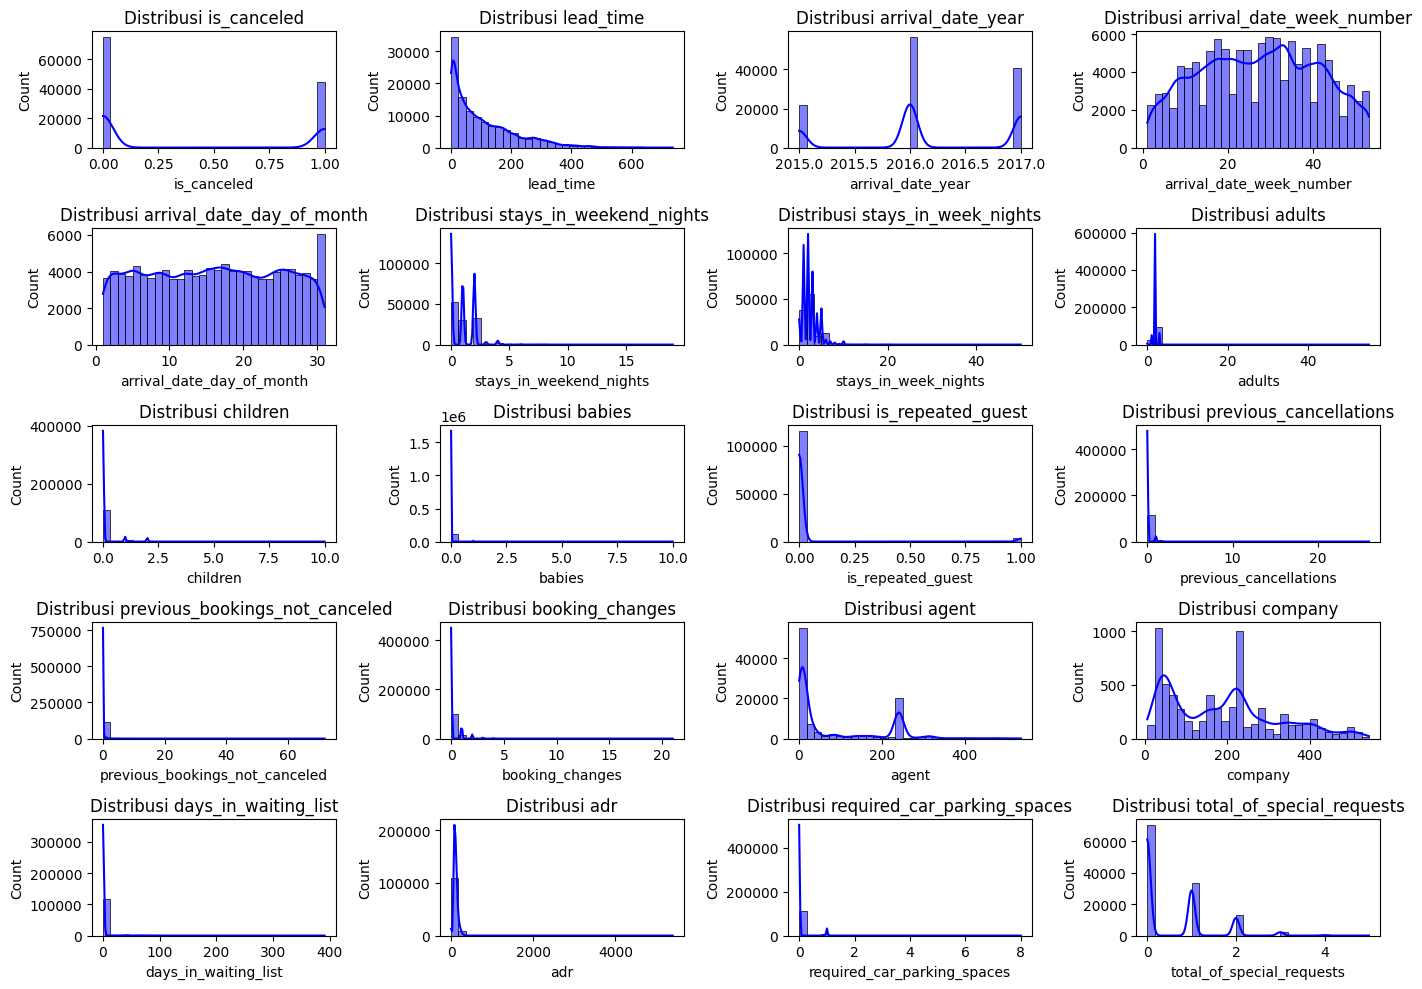

In [4]:
plt.figure(figsize=(14, 10))
for i, column in enumerate(num_cols, 1):
    plt.subplot(5, 4, i)
    sns.histplot(df[column], bins=30, kde=True, color='blue')
    plt.title(f'Distribusi {column}')
plt.tight_layout()
plt.show()

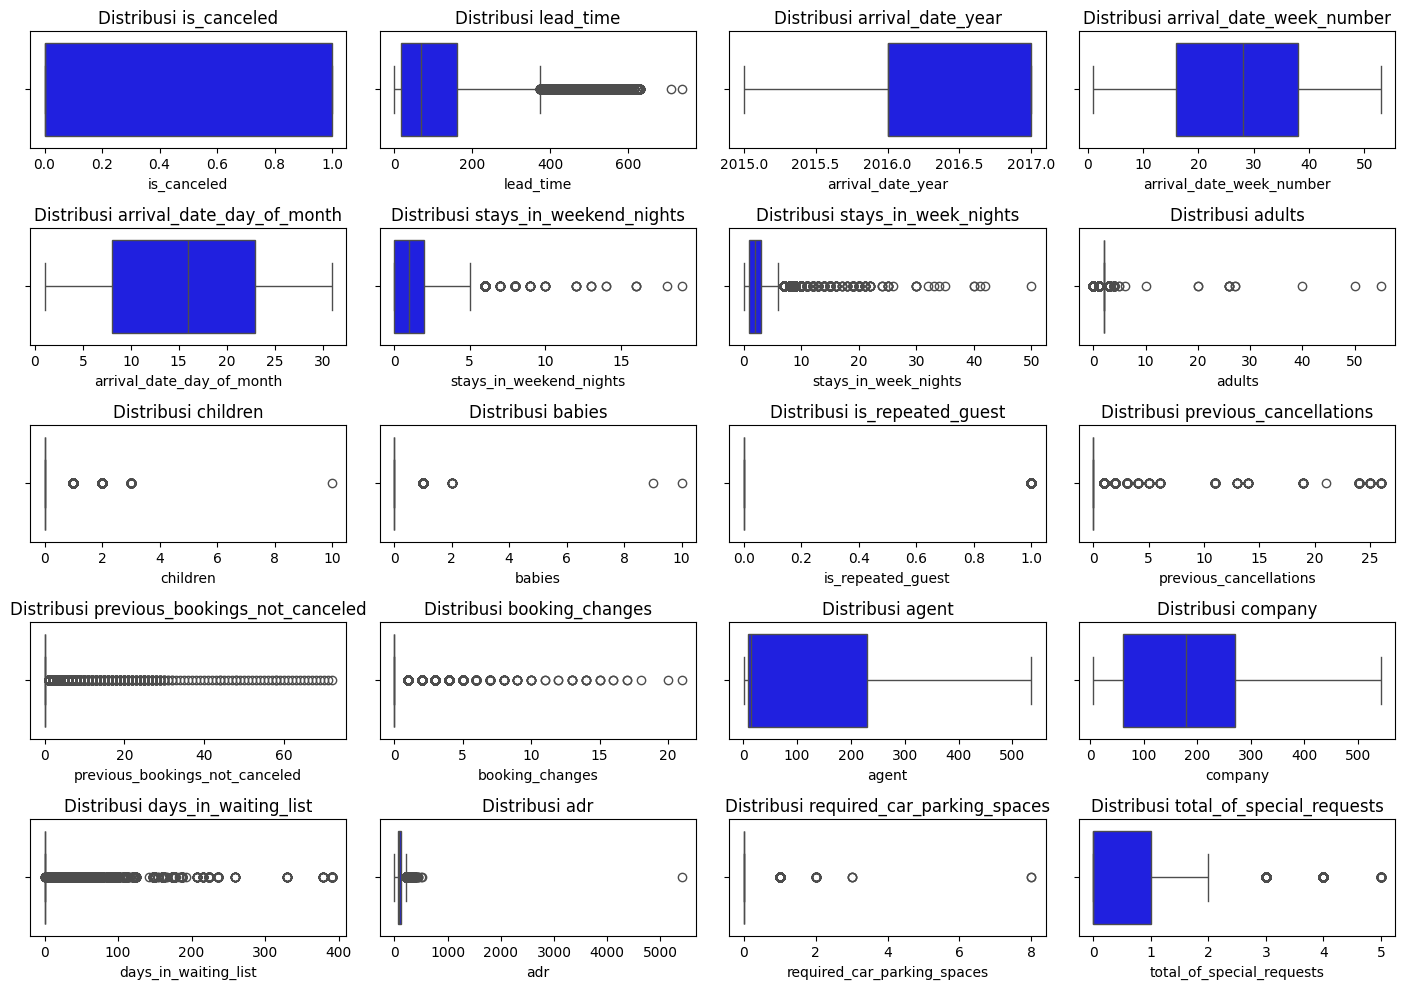

In [5]:
plt.figure(figsize=(14, 10))
for i, column in enumerate(num_cols, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x = df[column], color='blue')
    plt.title(f'Distribusi {column}')
plt.tight_layout()
plt.show()

## 2.3 Ringkasan Analisis Data Gathering

### 1. Ukuran dan Struktur Data
Dataset awal memiliki **119.390 baris dan 32 kolom**.

### 2. Tipe Data
Kolom-kolom dalam dataset terdiri dari:
*   **Integer (int64):** 16 kolom
*   **Float (float64):** 4 kolom
*   **Object (object):** 12 kolom

Beberapa kolom penting seperti `reservation_status_date` masih bertipe `object` dan perlu dikonversi ke tipe data `datetime` untuk analisis berbasis waktu.

### 3. Distribusi Variabel Target (`is_canceled`)
Variabel target `is_canceled` menunjukkan:
*   **Tidak Dibatalkan (0):** 75.166 pemesanan (sekitar 62.96%)
*   **Dibatalkan (1):** 44.224 pemesanan (sekitar 37.04%)

Distribusi kelas target menunjukan tidak keseimbangan pada jumlahnya, sehingga perlu ditangani agar model tidak bias atau salah menebak.

### 4. Missing Values (Nilai Hilang)
Analisis menunjukkan beberapa kolom memiliki nilai hilang:
*   `children`: 4 nilai hilang (0.003%)
*   `country`: 488 nilai hilang (0.41%)
*   `agent`: 16.340 nilai hilang (13.69%)
*   `company`: 112.593 nilai hilang (94.30%)

### 5. Duplikasi Data
Dataset mengandung **31.994 baris duplikat**

### 6. Anomali (Outlier) / Nilai Tidak Wajar
Beberapa kolom menunjukkan potensi nilai anomali atau tidak wajar yang perlu dibersihkan:
*   `adults`: Terdapat nilai `0`, `40`, `50`, `55` dewasa yang mungkin tidak masuk akal untuk satu pemesanan, atau menunjukkan data error.
*   `children`: Terdapat nilai `10` anak, yang bisa dianggap sangat tinggi.
*   `babies`: Terdapat nilai `9` atau `10` bayi, yang juga sangat tinggi.
*   `adr`: Beberapa nilai `0` (Average Daily Rate) mungkin merupakan anomali karena jarang sekali hotel tidak mengenakan biaya.
*   `required_car_parking_spaces`: Terdapat nilai `8` yang kemungkinan merupakan kesalahan input atau outlier yang ekstrim.


# 2. Data Prepocessing

In [6]:
df.dropna(subset=['country'], inplace=True)
df.dropna(subset=['children'], inplace=True)
df.drop(columns=['company'], inplace=True)

df.drop_duplicates(inplace=True)
df['reservation_status_date'] = pd.to_datetime(df['reservation_status_date'])

filter_guests = (df['adults'] + df['children'] + df['babies']) > 0
df = df[filter_guests]

filter_adr = (df['adr'] >= 0) & (df['adr'] < 5000)
df = df[filter_adr]

df = df[df['adults'] <= 50]

from sklearn.model_selection import train_test_split

X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Sklearn imputer median
from sklearn.impute import SimpleImputer

imputer_agent = SimpleImputer(strategy='median')
X_train['agent'] = imputer_agent.fit_transform(X_train[['agent']])
X_test['agent'] = imputer_agent.transform(X_test[['agent']])

# Transformasi Logaritma dan Square Root
X_train['lead_time'] = np.log1p(X_train['lead_time'])
X_test['lead_time'] = np.log1p(X_test['lead_time'])

X_train['adr'] = np.sqrt(X_train['adr'])
X_test['adr'] = np.sqrt(X_test['adr'])

# Handling Outlier Tidak Wajar (Data Error)

# Batasi babies maksimal 3 (Asumsi masuk akal)
X_train.loc[X_train['babies'] > 3, 'babies'] = 3
X_test.loc[X_test['babies'] > 3, 'babies']   = 3

# Parkir: Batasi maksimal 3 mobil per kamar
X_train.loc[X_train['required_car_parking_spaces'] > 3, 'required_car_parking_spaces'] = 3
X_test.loc[X_test['required_car_parking_spaces'] > 3, 'required_car_parking_spaces']   = 3

# Durasi Menginap (Total Nights)
X_train['total_nights'] = X_train['stays_in_weekend_nights'] + X_train['stays_in_week_nights']
X_test['total_nights'] = X_test['stays_in_weekend_nights'] + X_test['stays_in_week_nights']

# Jika lebih dari 50 malam, kita mentokkan jadi 50
X_train.loc[X_train['total_nights'] > 50, 'total_nights'] = 50
X_test.loc[X_test['total_nights'] > 50, 'total_nights']   = 50

Penjelasan Data Cleaning
### 1. Data Cleaning Sebelum Split Data
Langkah-langkah ini dilakukan pada seluruh dataset (`df`) sebelum dibagi menjadi *training* dan *testing set*. Tujuannya adalah untuk memastikan kualitas data secara keseluruhan dan menghindari *data leakage*.

*   **Penanganan Missing Values:**
    *   Gunakan `dropna` pada kolom `children` dan `country`, karena memiliki presentasi missing value yang rendah
    *  `Drop` kolom `company` secara keseluruhan karena memiliki presentase missing value yang sangat tinggi

*   **Penanganan Duplikasi Data:**
    *   Baris duplikat dihapus dari dataset untuk mencegah bias dan *overfitting*.

*   **Konversi Tipe Data:**
    *   Kolom `reservation_status_date` dikonversi dari tipe `object` menjadi `datetime` untuk memungkinkan ekstraksi fitur berbasis waktu atau analisis kronologis.

*   **Penanganan Outlier/Nilai Tidak Wajar:**
    *   **Jumlah Tamu:** Baris dengan total `adults + children + babies` sama dengan `0` dihapus. Pemesanan hotel seharusnya memiliki setidaknya satu tamu.
    *   **Average Daily Rate (ADR):** Baris dengan nilai `adr` di luar rentang `0` hingga `5000` dihapus. Nilai `0` seringkali merupakan *outlier* (karena hotel jarang gratis), dan nilai di atas `5000` dianggap ekstrem yang mungkin merupakan kesalahan input.
    *   **Jumlah Dewasa (`adults`):** Baris dengan nilai `adults` lebih dari `50` dihapus untuk mengeliminasi *outlier* yang tidak masuk akal.

### 2. Split Data

*   Dataset dibagi menjadi fitur (`X`) dan target (`y`), di mana `y` adalah kolom `is_canceled`.
*   Kemudian, data dibagi menjadi *training set* (`X_train`, `y_train`) dan *testing set* (`X_test`, `y_test`) dengan rasio `70:30`.
*   Penggunaan `stratify=y` memastikan bahwa rasio kelas target (`is_canceled`) tetap terjaga antara *training* dan *testing set*, yang penting untuk *imbalanced dataset*.

### 3. Data Cleaning Setelah Split Data (Diterapkan pada X_train & X_test secara terpisah)
Lakukan split data terlebih dahulu untuk data cleaning yang mengandung perhitungan statistik guna untuk mencegah adanya data leakage antara data train dan data test

*   **Imputasi Missing Values (Kolom 'agent'):**
    *   Nilai hilang pada kolom `agent` diisi menggunakan *median* dari kolom `agent` pada *training set*. *Median* dipilih karena kolom `agent` cenderung memiliki distribusi yang tidak normal dan banyak *outlier*.

*   **Transformasi Skala (Mengurangi Skewness):**
    *   Kolom `lead_time` ditransformasi menggunakan `np.log1p` (logaritma natural plus 1) untuk mengurangi *skewness* kanan dan membuat distribusinya lebih mendekati normal.
    *   Kolom `adr` ditransformasi menggunakan `np.sqrt` (akar kuadrat) untuk alasan serupa, yaitu mengurangi *skewness* dan dampak *outlier*.

*   **Penanganan Outlier/Nilai Tidak Wajar (Pembatasan Maksimal):**
    *   **`babies`:** Nilai `babies` yang lebih dari `3` dibatasi menjadi `3` (dianggap sebagai jumlah bayi maksimal yang masuk akal dalam satu pemesanan).
    *   **`required_car_parking_spaces`:** Nilai `required_car_parking_spaces` yang lebih dari `3` dibatasi menjadi `3` (dianggap sebagai jumlah slot parkir maksimal yang masuk akal per pemesanan).

*   **Feature Engineering (Kolom Durasi Menginap):**
    *   Kolom `total_nights` dibuat dengan menjumlahkan `stays_in_weekend_nights` dan `stays_in_week_nights`.
    *   Nilai `total_nights` yang lebih dari `50` dibatasi menjadi `50` untuk menampung *outlier* ekstrem atau kesalahan input pada durasi menginap yang sangat panjang.

# Feature Extraction

In [7]:
X_train['total_guests'] = X_train['adults'] + X_train['children'] + X_train['babies']
X_test['total_guests'] = X_test['adults'] + X_test['children'] + X_test['babies']

X_train['is_family'] = np.where((X_train['children'] > 0) | (X_train['babies'] > 0), 1, 0)
X_test['is_family'] = np.where((X_test['children'] > 0) | (X_test['babies'] > 0), 1, 0)

X_train['total_previous_bookings'] = X_train['previous_cancellations'] + X_train['previous_bookings_not_canceled']
X_test['total_previous_bookings'] = X_test['previous_cancellations'] + X_test['previous_bookings_not_canceled']

X_train['cancellation_rate_history'] = X_train['previous_cancellations'] / (X_train['total_previous_bookings'] + 0.01)
X_test['cancellation_rate_history'] = X_test['previous_cancellations'] / (X_test['total_previous_bookings'] + 0.01)

X_train['room_type_changed'] = np.where(X_train['reserved_room_type'] != X_train['assigned_room_type'], 1, 0)
X_test['room_type_changed'] = np.where(X_test['reserved_room_type'] != X_test['assigned_room_type'], 1, 0)

X_train['has_agent'] = np.where(X_train['agent'].notnull() & (X_train['agent'] != 0), 1, 0)
X_test['has_agent'] = np.where(X_test['agent'].notnull() & (X_test['agent'] != 0), 1, 0)

X_train['price_per_person'] = X_train['adr'] / (X_train['total_guests'] + 0.1)
X_test['price_per_person'] = X_test['adr'] / (X_test['total_guests'] + 0.1)

X_train['is_peak_season'] = X_train['arrival_date_month'].apply(lambda x: 1 if x in ['July', 'August'] else 0)
X_test['is_peak_season'] = X_test['arrival_date_month'].apply(lambda x: 1 if x in ['July', 'August'] else 0)

## Correlation

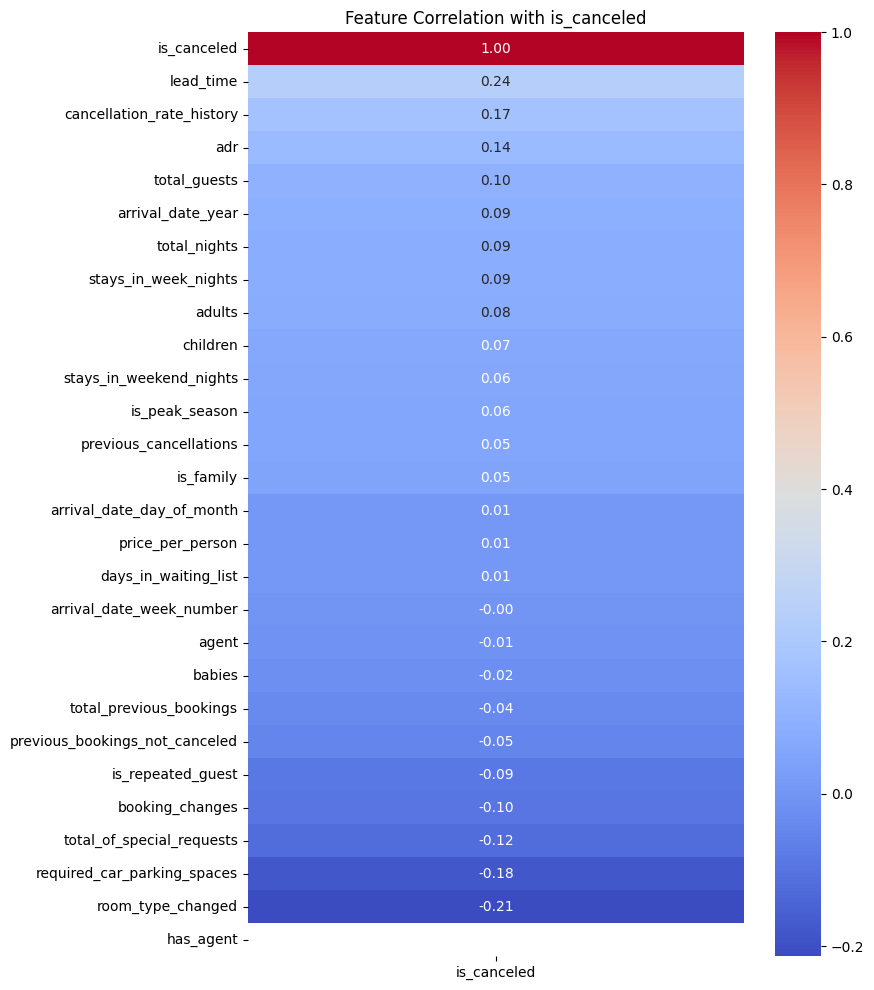

In [8]:
train_data = X_train.copy()
train_data['is_canceled'] = y_train

numeric_train_data = train_data.select_dtypes(include=np.number)
correlation_matrix = numeric_train_data.corr()

correlation_with_target = correlation_matrix['is_canceled'].sort_values(ascending=False)

plt.figure(figsize=(8, 12))
sns.heatmap(correlation_with_target.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation with is_canceled')
plt.show()

##  Statistical test (T-Test)

In [9]:
from scipy.stats import chi2_contingency, ttest_ind
import pandas as pd

def run_stat_test_on_train(X_data, y_data):
    # Gabungkan sementara untuk memudahkan analisis
    df_train_stat = pd.concat([X_data, y_data], axis=1)
    target = y_data.name

    numerical_cols = X_data.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = X_data.select_dtypes(include=['object', 'category']).columns

    significant_features = []
    non_significant_features = []

    print(f"--- ANALISIS SIGNIFIKANSI PADA TRAINING SET --- \n")

    # 1. Uji T-Test untuk Kolom Numerik (Terhadap Target)
    print(">> Kolom Numerik (T-Test):")
    for col in numerical_cols:
        group1 = df_train_stat[df_train_stat[target] == 0][col]
        group2 = df_train_stat[df_train_stat[target] == 1][col]

        # ttest_ind untuk melihat apakah rata-rata kedua grup (batal vs tidak) berbeda nyata
        stat, p_value = ttest_ind(group1, group2, nan_policy='omit')

        if p_value < 0.05:
            significant_features.append(col)
            status = "✅ SIGNIFIKAN"
        else:
            non_significant_features.append(col)
            status = "❌ TIDAK SIGNIFIKAN"

        print(f"- {col:28} : P-Value = {p_value:.4f} ({status})")

    print("\n" + "="*60 + "\n")

    # 2. Uji Chi-Square untuk Kolom Kategorikal
    print(">> Kolom Kategorikal (Chi-Square):")
    for col in categorical_cols:
        contingency_table = pd.crosstab(df_train_stat[col], df_train_stat[target])
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        if p_value < 0.05:
            significant_features.append(col)
            status = "✅ SIGNIFIKAN"
        else:
            non_significant_features.append(col)
            status = "❌ TIDAK SIGNIFIKAN"

        print(f"- {col:28} : P-Value = {p_value:.4f} ({status})")

    return significant_features, non_significant_features

# Jalankan fungsi
sig_cols, non_sig_cols = run_stat_test_on_train(X_train, y_train)

print(f"\nKesimpulan:")
print(f"Total Fitur Signifikan: {len(sig_cols)}")
print(f"Fitur yang disarankan dipertimbangkan untuk dihapus: {non_sig_cols}")

--- ANALISIS SIGNIFIKANSI PADA TRAINING SET --- 

>> Kolom Numerik (T-Test):
- lead_time                    : P-Value = 0.0000 (✅ SIGNIFIKAN)
- arrival_date_year            : P-Value = 0.0000 (✅ SIGNIFIKAN)
- arrival_date_week_number     : P-Value = 0.9937 (❌ TIDAK SIGNIFIKAN)
- arrival_date_day_of_month    : P-Value = 0.0360 (✅ SIGNIFIKAN)
- stays_in_weekend_nights      : P-Value = 0.0000 (✅ SIGNIFIKAN)
- stays_in_week_nights         : P-Value = 0.0000 (✅ SIGNIFIKAN)
- adults                       : P-Value = 0.0000 (✅ SIGNIFIKAN)
- children                     : P-Value = 0.0000 (✅ SIGNIFIKAN)
- babies                       : P-Value = 0.0000 (✅ SIGNIFIKAN)
- is_repeated_guest            : P-Value = 0.0000 (✅ SIGNIFIKAN)
- previous_cancellations       : P-Value = 0.0000 (✅ SIGNIFIKAN)
- previous_bookings_not_canceled : P-Value = 0.0000 (✅ SIGNIFIKAN)
- booking_changes              : P-Value = 0.0000 (✅ SIGNIFIKAN)
- agent                        : P-Value = 0.1238 (❌ TIDAK SIGNIFIKAN)

## Encoding

In [10]:
# --- 1. Fungsi Smoothing (agar lebih akurat) ---
def calc_smooth_mean(df, by, target, m=10):
    # Hitung jumlah (count) dan rata-rata (mean) per kategori
    agg = df.groupby(by)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Hitung rata-rata global (seluruh data train)
    global_mean = df[target].mean()

    # Rumus Smoothing:
    # Jika count besar, nilai akan mendekati 'means' (rata-rata kategori)
    # Jika count kecil, nilai akan ditarik ke 'global_mean'
    smooth = (counts * means + m * global_mean) / (counts + m)
    return smooth

# --- 2. PENERAPAN ---

# Kita butuh gabungan sementara X_train dan y_train untuk menghitung
train_temp = X_train.copy()
train_temp['target'] = y_train

# A. Country Risk dengan Smoothing
# m=10 artinya kita butuh minimal sekitar 10 data biar percaya sama rata-rata negara itu
country_map = calc_smooth_mean(train_temp, by='country', target='target', m=10)

X_train['country_risk'] = X_train['country'].map(country_map)
X_test['country_risk'] = X_test['country'].map(country_map)

# B. Agent Risk dengan Smoothing
agent_map = calc_smooth_mean(train_temp, by='agent', target='target', m=10)

X_train['agent_risk'] = X_train['agent'].map(agent_map)
X_test['agent_risk'] = X_test['agent'].map(agent_map)

# --- 3. HANDLING MISSING VALUES (NEGARA BARU DI TEST) ---
# Isi dengan rata-rata global training set
global_mean = y_train.mean()
X_test['country_risk'] = X_test['country_risk'].fillna(global_mean)
X_test['agent_risk'] = X_test['agent_risk'].fillna(global_mean)

# --- 4. DATA CLEANING LAINNYA (Sama seperti punya Anda) ---
cols_to_drop = ['assigned_room_type', 'reservation_status', 'reservation_status_date', 'country', 'agent']
# Tambahkan 'company' jika banyak kosongnya
if 'company' in X_train.columns:
    cols_to_drop.append('company')

X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test = X_test.drop(columns=cols_to_drop, errors='ignore')

month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
X_train['arrival_date_month'] = X_train['arrival_date_month'].map(month_map)
X_test['arrival_date_month'] = X_test['arrival_date_month'].map(month_map)

# --- 5. ONE-HOT ENCODING & ALIGNMENT ---
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Penyelarasan kolom
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Modeling

## XGBOOST MANUAL

In [11]:
X_train_manual = X_train.copy()
X_test_manual = X_test.copy()

# Inisialisasi Model XGBoost
model_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=9,
    learning_rate=0.05,
    scale_pos_weight=1.5, # Senjata rahasia untuk data tidak seimbang
    use_label_encoder=False,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='logloss',
    random_state=42
)

# Training
model_xgb.fit(X_train_manual, y_train)

# Prediksi
y_pred = model_xgb.predict(X_test_manual)

# Evaluasi
print("======= REPORT: MODEL XGBOOST MANUAL =======")
print(classification_report(y_test, y_pred))

======= REPORT: MODEL XGBOOST MANUAL =======
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     18839
           1       0.73      0.77      0.75      7192

    accuracy                           0.86     26031
   macro avg       0.82      0.83      0.82     26031
weighted avg       0.86      0.86      0.86     26031



## Feature Importance

In [12]:
importances = pd.DataFrame({
    'feature': X_train_manual.columns,
    'importance': model_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print(importances.tail(50))

                           feature  importance
11          previous_cancellations    0.031023
22       cancellation_rate_history    0.029735
27                    country_risk    0.029579
36           market_segment_Direct    0.027897
42      distribution_channel_TA/TO    0.026412
41        distribution_channel_GDS    0.020713
1                arrival_date_year    0.020202
55   customer_type_Transient-Party    0.018939
12  previous_bookings_not_canceled    0.018576
39        market_segment_Online TA    0.017819
0                        lead_time    0.015743
13                 booking_changes    0.014778
40     distribution_channel_Direct    0.011966
38    market_segment_Offline TA/TO    0.011853
29              hotel_Resort Hotel    0.009472
20                       is_family    0.009391
18                    total_nights    0.008305
37           market_segment_Groups    0.007666
43            reserved_room_type_B    0.007594
10               is_repeated_guest    0.007195
21         to

## XGBOOST (Training after Feature Importance)

In [13]:
# 1. Ambil list fitur yang importancenya > 0.005
features_to_keep = importances[importances['importance'] > 0.005]['feature'].tolist()

# Lihat Fitur yang dihapus
features_to_drop = set(X_train_manual.columns) - set(features_to_keep)
print("Fitur yang dihapus:")
for feature in sorted(features_to_drop):
    print(f"  - {feature}")

# Filter X_train dan X_test Anda
X_train_selected = X_train_manual.drop(columns=features_to_drop)
X_test_selected = X_test_manual.drop(columns=features_to_drop)

Fitur yang dihapus:
  - adults
  - arrival_date_day_of_month
  - customer_type_Group
  - has_agent
  - market_segment_Complementary
  - meal_FB
  - meal_HB
  - reserved_room_type_D
  - reserved_room_type_L
  - stays_in_weekend_nights


In [14]:
model_xgb = XGBClassifier(
    n_estimators=500,
    max_depth=10,
    learning_rate=0.03,
    scale_pos_weight=2.0,
    min_child_weight=2,
    gamma=0.1,
    subsample=0.85,
    colsample_bytree=0.85,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Training
model_xgb.fit(X_train_selected, y_train)

# Prediksi
y_pred_test = model_xgb.predict(X_test_selected)

# Evaluasi
print("======= REPORT: MODEL XGBOOST MANUAL PARAMETER =======")
print(classification_report(y_test, y_pred_test))

======= REPORT: MODEL XGBOOST MANUAL PARAMETER =======
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     18839
           1       0.70      0.81      0.75      7192

    accuracy                           0.85     26031
   macro avg       0.81      0.84      0.82     26031
weighted avg       0.86      0.85      0.86     26031



AUC Score for XGBoost : 0.9260


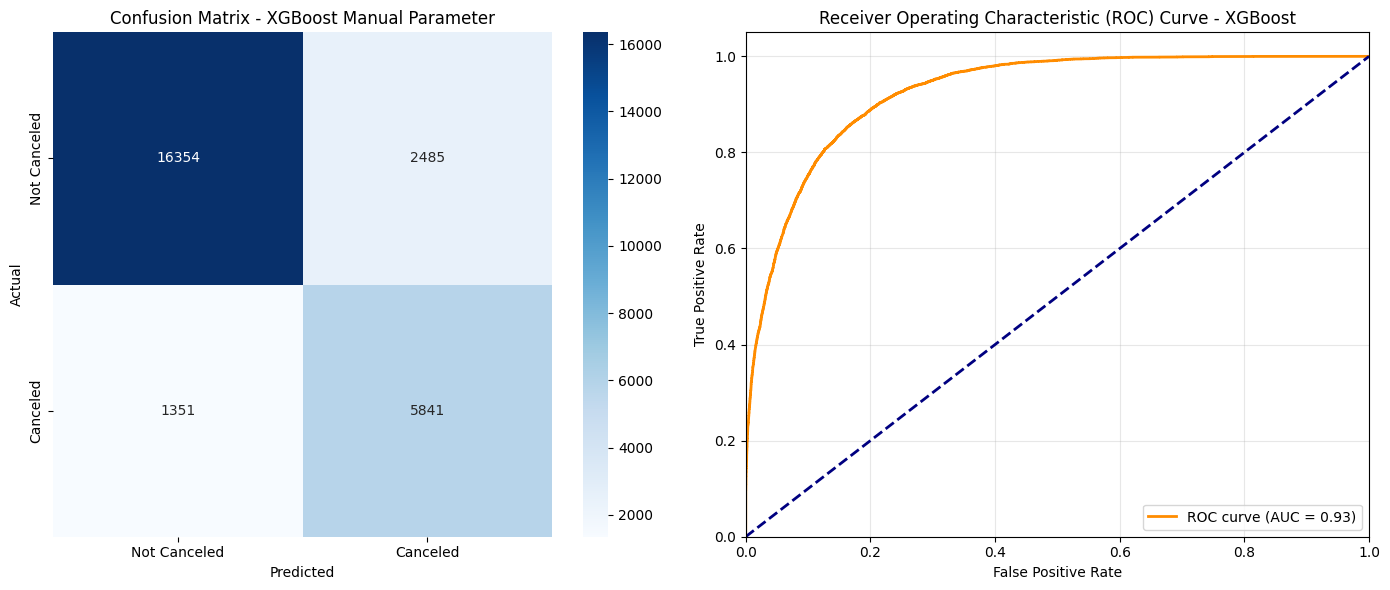

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Create a figure with two subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) # Create a 1 row, 2 column grid of subplots

# Plot 1: Confusion Matrix for XGBoost Manual Parameter
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Canceled', 'Canceled'],
            yticklabels=['Not Canceled', 'Canceled'], ax=axes[0]) # Plot on the first subplot
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')
axes[0].set_title('Confusion Matrix - XGBoost Manual Parameter')

# Ambil probabilitas untuk kelas 1 (Batal) dari model XGBoost
y_probs_untuned = model_xgb.predict_proba(X_test_selected)[:, 1]

# Hitung False Positive Rate (FPR) dan True Positive Rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_probs_untuned)

# Hitung Area Under the Curve (AUC)
roc_auc = auc(fpr, tpr)

print(f"AUC Score for XGBoost : {roc_auc:.4f}")

# Plot 2: ROC curve
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic (ROC) Curve - XGBoost')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Threshold Tuning

--- Hasil Threshold Tuning ---
Optimal Threshold for Best F1: 0.5120
Recall at this threshold: 0.8062
Precision at this threshold: 0.7090

======= REPORT: XGBOOST (RECALL TUNED) =======
              precision    recall  f1-score   support

           0       0.92      0.87      0.90     18839
           1       0.71      0.81      0.75      7192

    accuracy                           0.86     26031
   macro avg       0.82      0.84      0.83     26031
weighted avg       0.86      0.86      0.86     26031



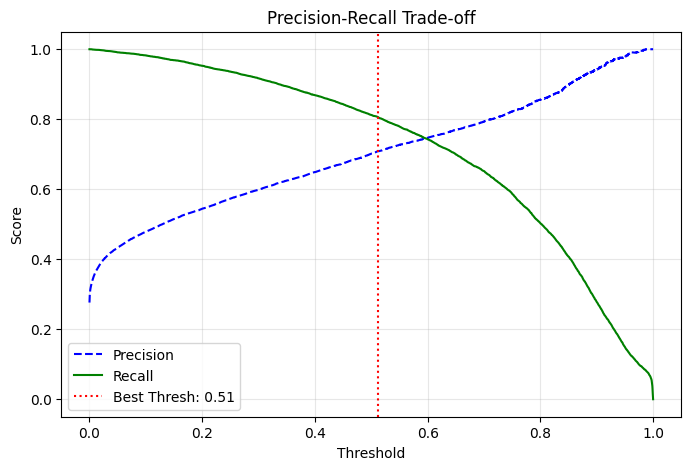

In [16]:
from sklearn.metrics import precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import numpy as np

# 1. Ambil probabilitas untuk kelas 1 (Batal)
y_probs = model_xgb.predict_proba(X_test_selected)[:, 1]

# 2. Hitung precision, recall, dan thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Cari threshold terbaik berdasarkan F1-Score
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-5)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"--- Hasil Threshold Tuning ---")
print(f"Optimal Threshold for Best F1: {best_threshold:.4f}")
print(f"Recall at this threshold: {recalls[best_idx]:.4f}")
print(f"Precision at this threshold: {precisions[best_idx]:.4f}")

# 4. Terapkan Threshold pada Prediksi
y_pred_tuned = (y_probs >= best_threshold).astype(int)

# 5. Tampilkan Report Final
print("\n======= REPORT: XGBOOST (RECALL TUNED) =======")
print(classification_report(y_test, y_pred_tuned))

# 6. Visualisasi Trade-off
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.axvline(x=best_threshold, color='red', linestyle=':', label=f'Best Thresh: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Trade-off')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

✅ Final AUC Score: 0.9260


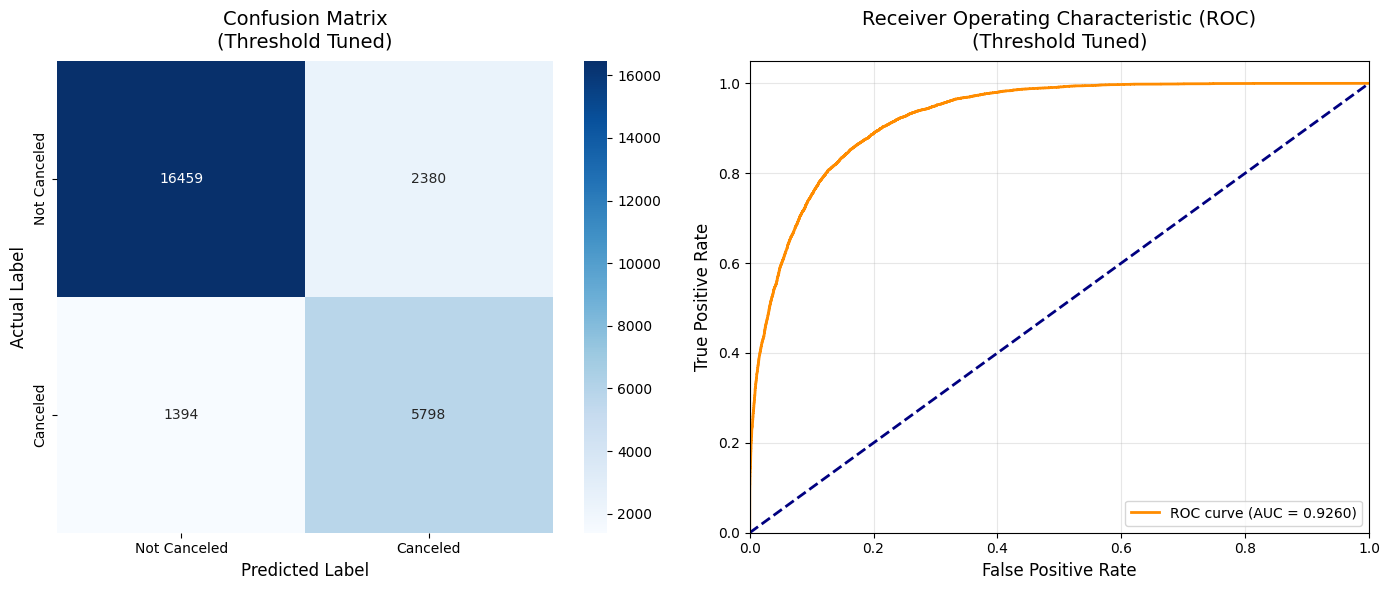

In [20]:
# Import library yang dibutuhkan (jika belum)
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)

# Hitung ROC Curve & AUC
y_probs_tuned = model_xgb.predict_proba(X_test_selected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs_tuned)
roc_auc = auc(fpr, tpr)
print(f"✅ Final AUC Score: {roc_auc:.4f}")

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Canceled', 'Canceled'],
            yticklabels=['Not Canceled', 'Canceled'],
            ax=ax[0]) # Perhatikan parameter ax=ax[0]

ax[0].set_ylabel('Actual Label', fontsize=12)
ax[0].set_xlabel('Predicted Label', fontsize=12)
ax[0].set_title('Confusion Matrix\n(Threshold Tuned)', fontsize=14, pad=10)


ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Garis diagonal
ax[1].set_xlim([0.0, 1.0])
ax[1].set_ylim([0.0, 1.05])
ax[1].set_xlabel('False Positive Rate', fontsize=12)
ax[1].set_ylabel('True Positive Rate', fontsize=12)
ax[1].set_title('Receiver Operating Characteristic (ROC)\n(Threshold Tuned)', fontsize=14, pad=10)
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Cross Validation

### Hasil Cross Validation

*Cross-validation* dilakukan dengan menggunakan *StratifiedKFold* sebanyak 5 lipatan (*folds*) untuk mengevaluasi stabilitas dan generalisasi model XGBoost. Metrik yang digunakan adalah *F1-Weighted Score*, yang cocok untuk dataset dengan kelas yang tidak seimbang (seperti pada kasus pembatalan hotel).

Hasil yang diperoleh adalah sebagai berikut:

*   **Hasil tiap Fold:** `[0.84970193 0.84822525 0.85364278 0.84987983 0.84665837]`
    *   Angka-angka ini menunjukkan F1-Score yang dicapai oleh model pada setiap dari 5 lipatan *cross-validation*.

*   **Rata-rata F1-Score CV: 0.8496**
    *   Nilai rata-rata ini adalah indikator utama performa model yang diharapkan pada data yang belum pernah dilihat. F1-Score sebesar 0.8496 menunjukkan bahwa model memiliki keseimbangan yang baik antara presisi dan *recall* dalam mengidentifikasi pembatalan.

*   **Standar Deviasi: 0.0023**
    *   Standar deviasi yang sangat rendah (0.0023) menunjukkan bahwa model sangat **stabil**. Ini berarti performa model tidak terlalu bervariasi ketika dilatih dan diuji pada subset data yang berbeda. Model tidak *overfit* pada satu subset data tertentu dan dapat diharapkan memberikan hasil yang konsisten pada data baru.

**Implikasi Bisnis:**
Hasil *cross-validation* ini mengkonfirmasi bahwa model XGBoost yang telah dioptimalkan tidak hanya memiliki performa yang baik (*F1-Score* rata-rata tinggi) tetapi juga **robust dan stabil**. Ini berarti model tersebut dapat diandalkan untuk digunakan dalam operasional sehari-hari hotel, dengan keyakinan bahwa prediksinya akan konsisten dan tidak mudah terpengaruh oleh variasi kecil dalam data.

In [18]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# 1. Tentukan skema CV (5-Fold artinya data dibagi 5 bagian)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Hitung skor CV (Gunakan f1_weighted karena itu yang paling seimbang)
cv_results = cross_val_score(model_xgb, X_train_selected, y_train, cv=skf, scoring='f1_weighted')

print(f"Hasil tiap Fold: {cv_results}")
print(f"Rata-rata F1-Score CV: {cv_results.mean():.4f}")
print(f"Standar Deviasi: {cv_results.std():.4f}")

Hasil tiap Fold: [0.84970193 0.84822525 0.85364278 0.84987983 0.84665837]
Rata-rata F1-Score CV: 0.8496
Standar Deviasi: 0.0023


Sedang membuat grafik SHAP...


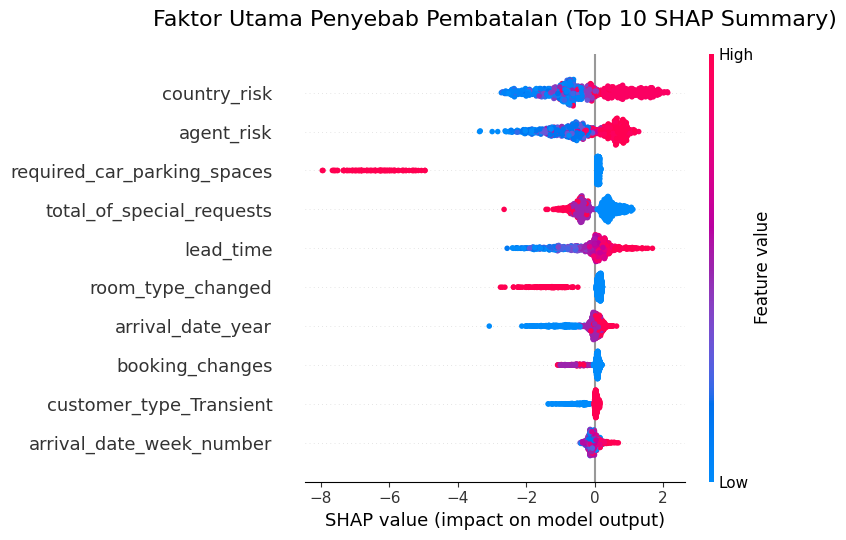

In [19]:
# 1. Inisialisasi JavaScript
shap.initjs()

# 2. Buat Explainer (Khusus XGBoost pakai TreeExplainer biar cepat)
explainer = shap.TreeExplainer(model_xgb)

# 3. Ambil Sampel Data (Misal 1000 data saja) untuk menghemat komputasi komputer
X_shap_sample = X_test_selected.sample(n=1000, random_state=42)

# 4. Hitung SHAP Values
shap_values = explainer.shap_values(X_shap_sample)

# 5. Visualisasi Utama (Summary Plot)
print("Sedang membuat grafik SHAP...")
plt.figure(figsize=(10, 8)) # Mengatur ukuran gambar biar lega
shap.summary_plot(shap_values, X_shap_sample, max_display=10, show=False)
plt.title("Faktor Utama Penyebab Pembatalan (Top 10 SHAP Summary)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Insight Project

### Penjelasan Perbandingan antara Hasil Modeling Asli dengan Hasil Modeling optimasi Threshold Tuning

#### 1. Model XGBoost Original (Baseline - Threshold 0.5)
Pada tahap awal, model dijalankan menggunakan parameter manual dengan *threshold* standar (0.5). Hasil evaluasinya adalah sebagai berikut:


* **Akurasi (Accuracy): 85%**
    * Model mampu memprediksi dengan benar apakah pesanan akan dibatalkan atau tidak sebanyak 85% dari seluruh total data uji.
* **Presisi (Precision) untuk Pembatalan (Kelas 1): 70%**
    * Artinya, dari semua pesanan yang diberi label "Batal" oleh model, 70% di antaranya memang benar-benar batal. Masih terdapat risiko 30% *false alarm* (tamu yang dikira batal padahal tetap datang).
* **Recall untuk Pembatalan (Kelas 1): 81%**
    * Model berhasil menangkap 81% dari seluruh pesanan yang sebenarnya batal. Ini menunjukkan performa yang cukup kuat dalam mendeteksi risiko kehilangan pendapatan sejak awal.
* **F1-Score untuk Pembatalan (Kelas 1): 75%**
    * Menunjukkan keseimbangan rata-rata antara presisi dan recall pada tahap awal pengembangan model.
* **AUC Score: 0.9260**
    * Nilai AUC score yang dihasilkan setelah threshold tuning, masih di angka yang sama.



#### 2. Model XGBoost Optimized (Final - Threshold 0.5120)
Setelah dilakukan *Threshold Tuning* untuk mencari titik keseimbangan paling efisien bagi operasional hotel, performa model meningkat menjadi:

* **Akurasi (Accuracy): 86%**
    * Terjadi peningkatan akurasi sebesar **1%**. Model kini lebih handal dengan tingkat kebenaran prediksi total mencapai 86%.
* **Presisi (Precision) untuk Pembatalan (Kelas 1): 71%**
    * Efisiensi model meningkat. Dengan presisi 71%, hotel dapat lebih percaya diri dalam mengambil tindakan (seperti menagih deposit) karena tingkat kesalahan prediksi "Batal" berkurang.
* **Recall untuk Pembatalan (Kelas 1): 81%**
    * Model tetap mempertahankan kemampuannya untuk mengidentifikasi **81% dari semua pesanan yang sebenarnya dibatalkan**. Dari 100 pesanan yang berisiko batal, model sukses menangkap 81 di antaranya untuk dilakukan mitigasi *revenue leakage*.
* **F1-Score untuk Pembatalan (Kelas 1): 75%**
    * Meskipun metrik lain meningkat, F1-score tetap stabil, menandakan optimasi ini tidak merusak keseimbangan performa model secara keseluruhan.
* **AUC Score: 0.9260**
    * Meskipun terdapat sedikit penyesuaian nilai, skor AUC tetap berada di kategori **Excellent**. Hal ini menjamin bahwa model tetap memiliki kemampuan diskriminasi yang sangat baik dalam situasi data yang bervariasi.



### Kesimpulan Optimasi Model
Perubahan *threshold* ke angka **0.5120** terbukti memberikan performa yang lebih "cerdas". Model akhir ini dipilih karena mampu **meningkatkan akurasi dan presisi** tanpa mengorbankan nilai *recall*, sehingga meminimalisir kesalahan operasional sekaligus memaksimalkan penyelamatan pendapatan hotel.


### Implikasi Bisnis
Dengan *recall* sebesar 81% untuk kelas pembatalan, hotel memiliki alat yang kuat untuk mengidentifikasi sebagian besar pemesanan yang berisiko tinggi untuk dibatalkan. Ini memungkinkan hotel untuk:
1.  **Mengurangi *Revenue Leakage*:** Dengan mengidentifikasi 81% dari pesanan yang akan dibatalkan, hotel dapat mengambil tindakan proaktif seperti menawarkan insentif untuk mempertahankan pesanan, melakukan *overbooking* yang lebih aman, atau memasarkan kembali kamar lebih awal, sehingga kerugian pendapatan dapat diminimalisir.
2.  **Optimasi Manajemen Stok Kamar:** Hotel dapat lebih akurat menyesuaikan strategi *overbooking* mereka, mengurangi risiko kamar kosong atau menolak tamu akibat pembatalan yang tidak terduga.
3.  **Strategi Pemasaran Bertarget:** Dengan memahami pola pembatalan, hotel dapat mengembangkan strategi pemasaran yang lebih efektif untuk segmen pelanggan tertentu atau pada periode waktu tertentu.

### Faktor Utama Penyebab Pembatalan (Berdasarkan SHAP Summary):

1. `country_risk` & `agent_risk`: Dua fitur teratas yang memiliki nilai tertinggi. Titik merah di sisi kanan menunjukkan bahwa jika seorang tamu berasal dari negara dengan risiko pembatalan tinggi atau memesan melalui agen yang sering bermasalah, kemungkinan besar mereka akan batal.

2. `lead_time`: Titik merah cenderung berada di sisi kanan. Ini mengonfirmasi teori bisnis bahwa semakin lama jarak antara waktu pemesanan dan hari kedatangan, semakin besar risiko tamu tersebut berubah pikiran atau menemukan opsi lain.

3. `required_car_parking_spaces`: Titik merah pada fitur ini menumpuk jauh di sisi kiri. Tamu yang meminta lahan parkir hampir tidak pernah membatalkan pesanan. Secara bisnis, tamu yang membawa mobil biasanya adalah wisatawan domestik atau keluarga yang rencana perjalanannya sudah sangat matang.

4. `room_type_changed`: Jika tamu melakukan perubahan tipe kamar (nilai merah di sisi kiri), mereka cenderung tetap datang. Aktivitas mengubah pesanan menunjukkan interaksi dan niat yang kuat dari tamu terhadap reservasi mereka.

5. `total_of_special_requests`: Semakin banyak permintaan khusus (merah), semakin kecil kemungkinan mereka batal. Tamu yang "rewel" atau punya banyak keinginan biasanya adalah tamu yang sudah pasti ingin menginap di hotel Anda.

6. `booking_changes`: Mirip dengan perubahan tipe kamar, setiap perubahan pada detail pesanan merupakan sinyal bahwa tamu tersebut aktif mengelola rencana perjalanannya dan kemungkinan besar akan hadir.

7. `customer_type_Transient`: Tamu jenis Transient (perorangan/bukan grup) yang nilainya rendah (biru) cenderung memiliki risiko batal yang lebih tinggi dibandingkan tamu grup atau korporasi.

8. `arrival_date_year` &`arrival_date_week_number`: Menunjukkan adanya pengaruh musiman. Tahun atau minggu tertentu dalam setahun memiliki tren pembatalan yang berbeda, namun pengaruhnya tidak sekuat faktor risiko negara atau permintaan fasilitas (parkir/request).

In [21]:
import pickle

# Simpan model ke file pickle
filename = 'hotel_cancellation_prediction_model.pkl'
pickle.dump(model_xgb, open(filename, 'wb'))

print(f"Model berhasil disimpan sebagai '{filename}'")

Model berhasil disimpan sebagai 'hotel_cancellation_prediction_model.pkl'
